
#Watershed Segmentation.

In this example we will apply the openCV watershed algorithm to segment multiple touching objects from the background. The watershed algorithm is an example of a region growing segmentation algorithm. In order to use the watershed algorithm we must initially to prepare a marker image which outlines where the "flooding" sources/regions are for the watershed algorithm.  (Note that this example uses morphology operations. If you are not familar with these operations, they are discussed in the supplementary lesson 2: Morphology Operations)


**Housekeeping:** Import Libraries, read image

In [1]:
import numpy as np
import urllib.request
import numpy as np
import cv2
from matplotlib import pyplot as plt

def url_to_image(url):
	user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
	headers ={'User-Agent':user_agent,}
	request=urllib.request.Request(url,None,headers)
	resp = urllib.request.urlopen(request)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image



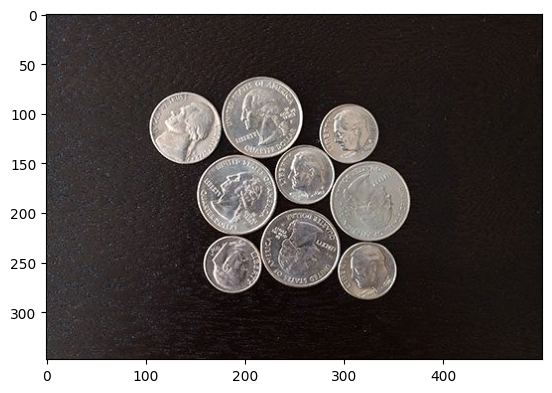

In [2]:

image_url = "https://www.pyimagesearch.com/wp-content/uploads/2015/10/watershed_coins_01.jpg"
image = url_to_image(image_url)
plt.imshow(image)

# Prepare marker Image

**Step 1**: We must intially convert the image to greyscale and they apply thresholding. As we are required to use the threshold technique, we are limited to using the watershed algorithm on images where we can easily firstly segment all the combined foreground objects from background (This includes images with uniform backgrounds such as the image shown).

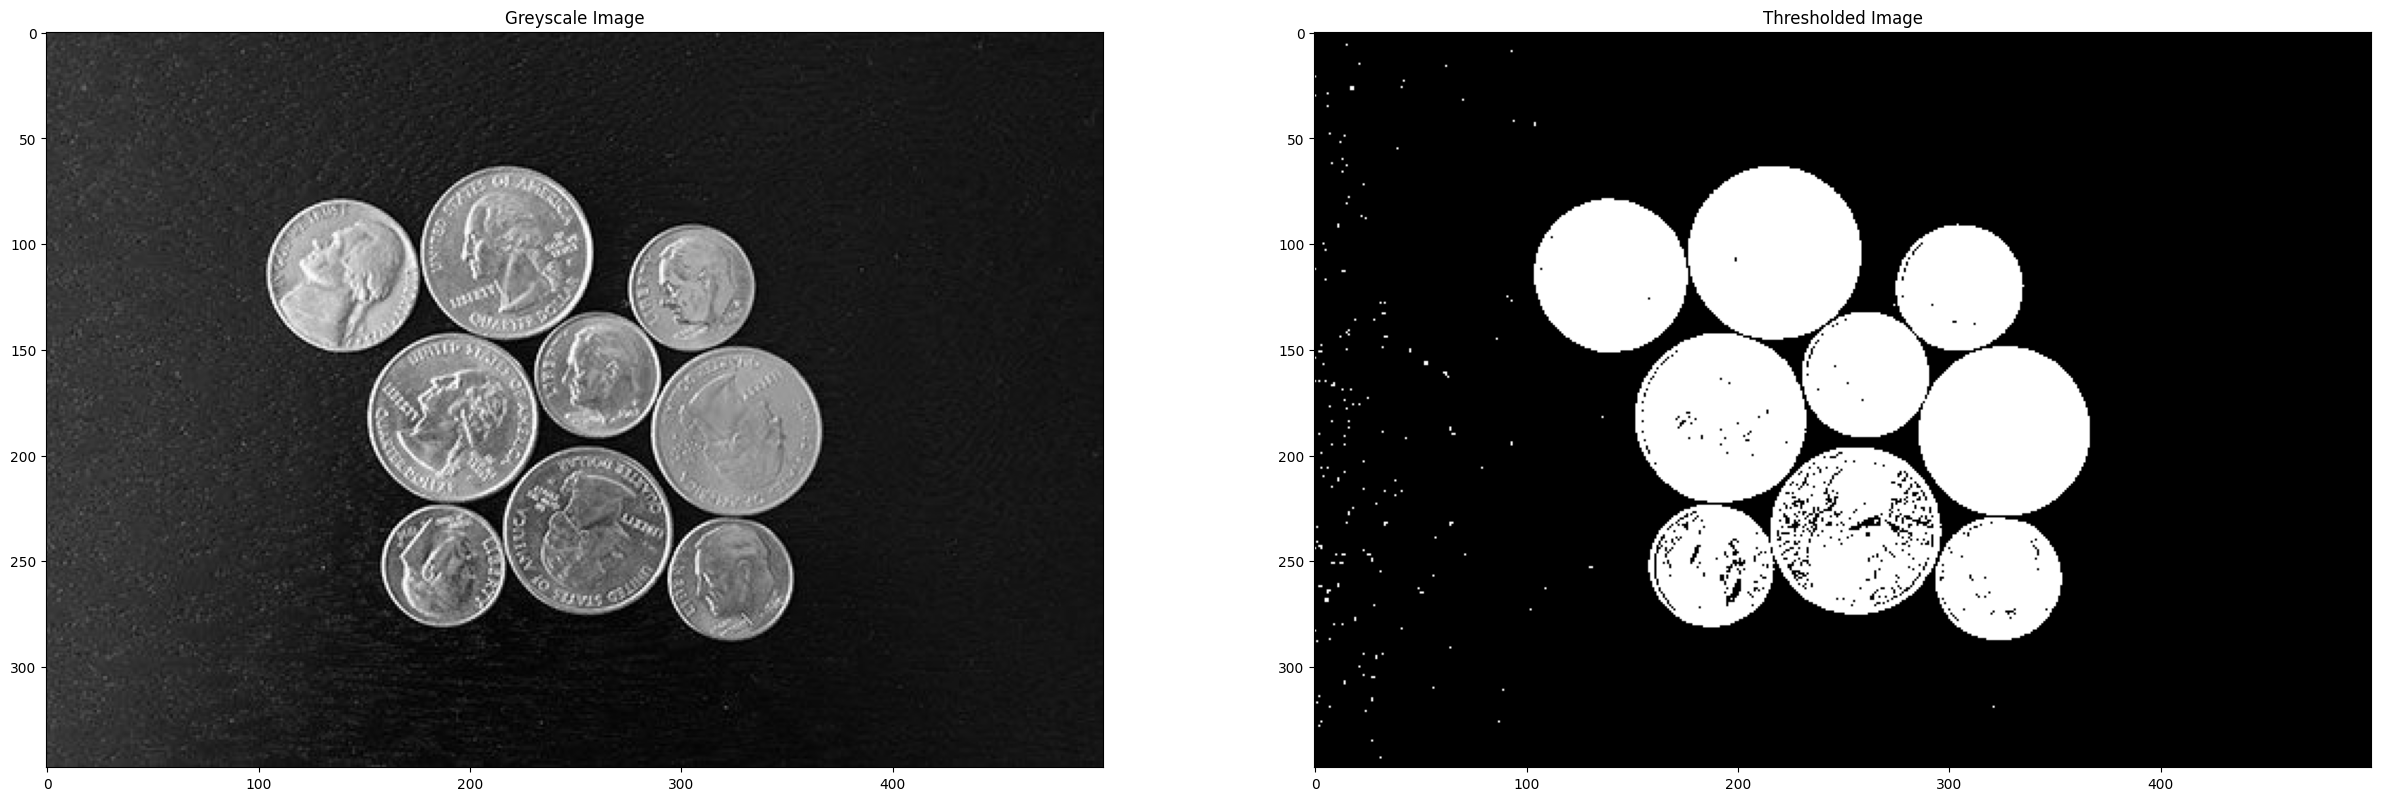

In [3]:
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Threshold the image

# Use this form of Threshold command if objects are dark on light background
#ret, thresh = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)
# Use this form of Threshold command if objects are light on a dark background.
ret, thresh = cv2.threshold(gray,80,255,cv2.THRESH_BINARY)

# Create plots
f, axarr = plt.subplots(1,2,figsize=(30,20))
axarr[0].imshow(gray,'gray')
axarr[0].title.set_text('Greyscale Image')
axarr[1].imshow(thresh,'gray')
axarr[1].title.set_text('Thresholded Image')


**Step 2**: We will then apply a closing operation to remove any holes in the image, this is follwed by an opening operating to remove the background noise.

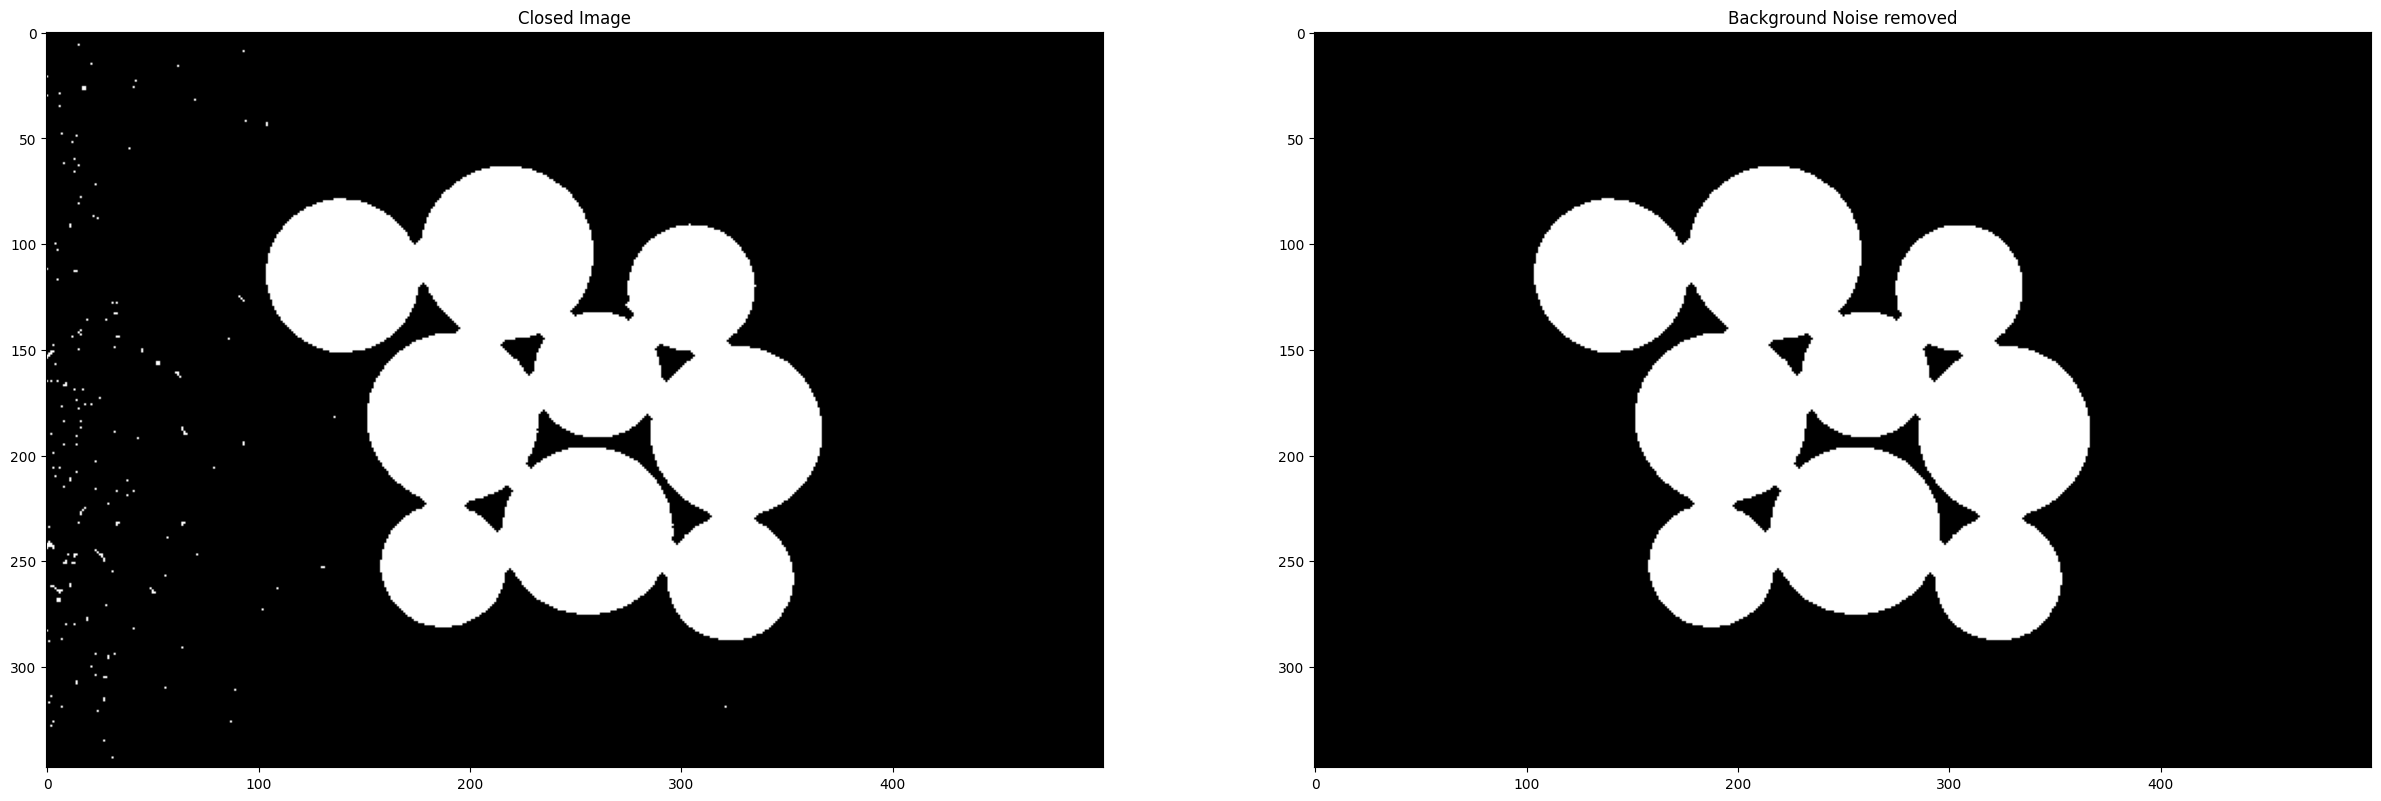

In [4]:
#Close this image
str1 = 3
str2 = 3

#  Define closing structuring element
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (str1,str1))

# Create closed version removing noise in the foreground objects.
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closingKernel,iterations = 2)

# noise removal
kernel = np.ones((str2,str2),np.uint8)
opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)

# Create plots
f, axarr = plt.subplots(1,2,figsize=(30,20))
axarr[0].imshow(closed,'gray')
axarr[0].title.set_text('Closed Image')
axarr[1].imshow(opening,'gray')
axarr[1].title.set_text('Background Noise removed')

**Step 3**: Here we will find the object centres by applying the distance transform. We then apply another threshold operation to produce a binary image that includes the object centres.

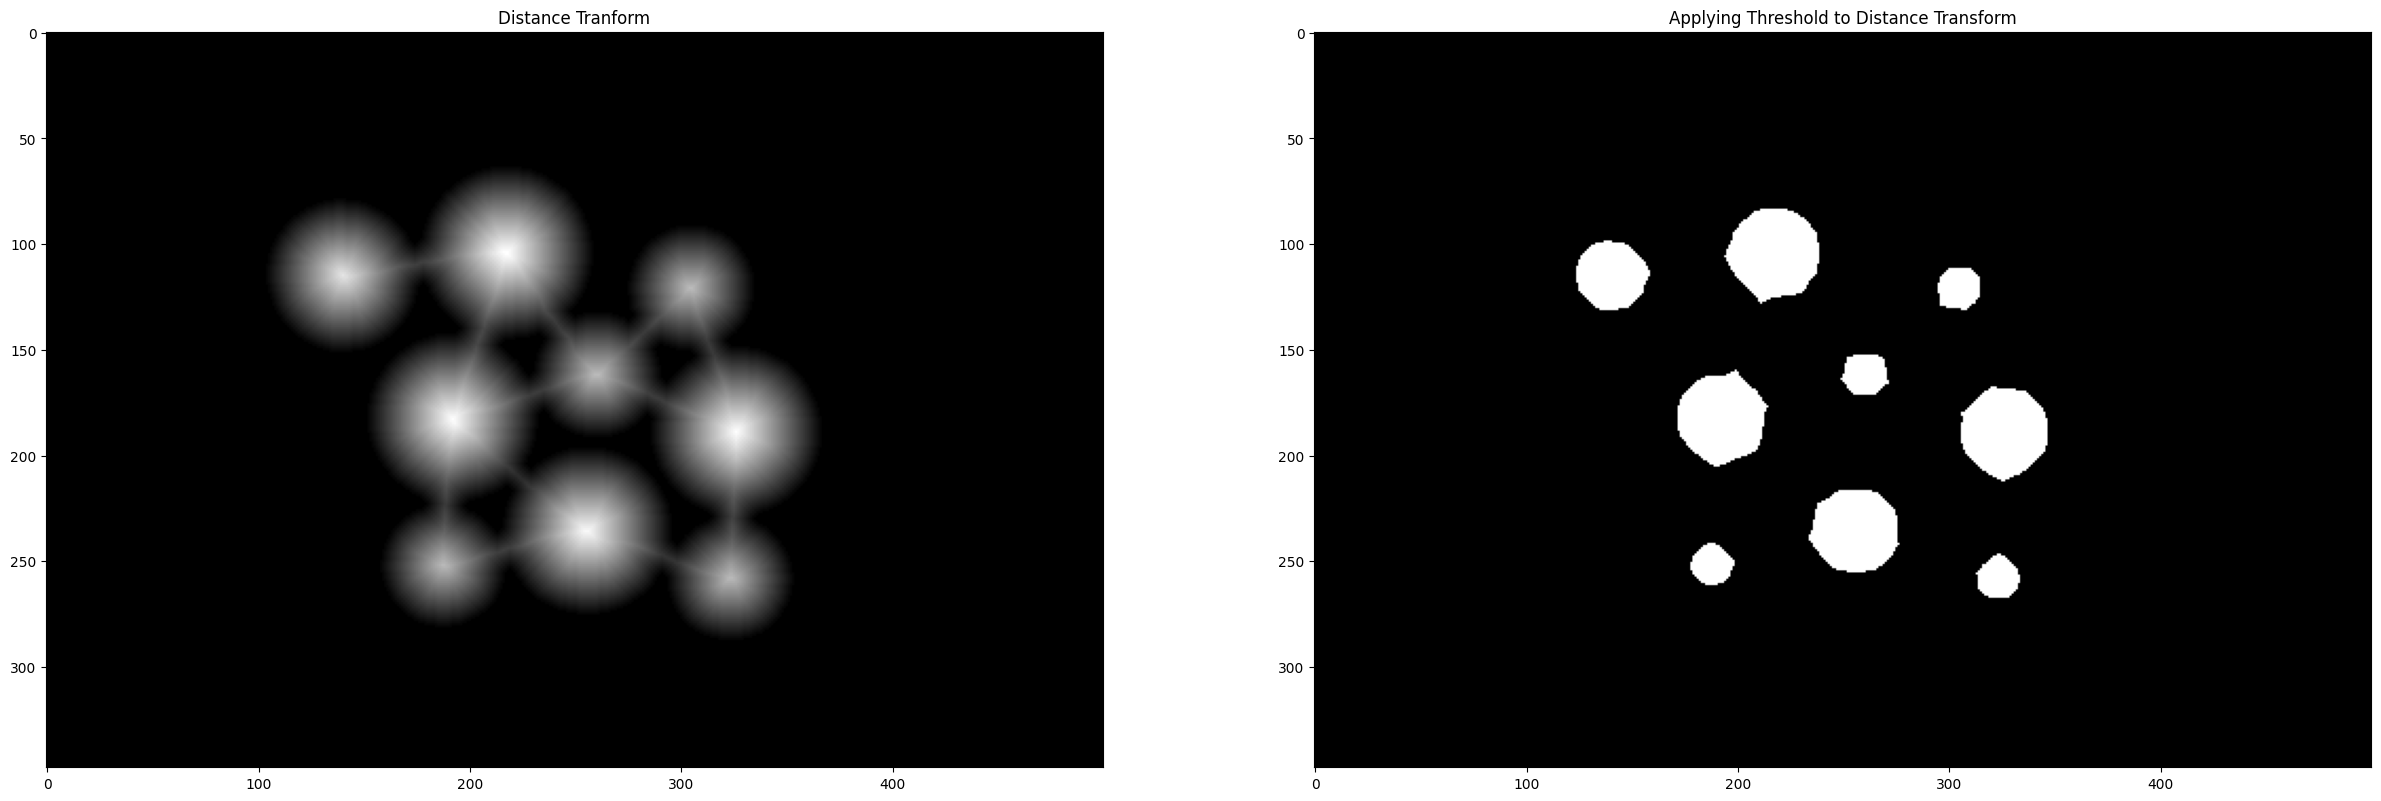

In [5]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

f, axarr = plt.subplots(1,2,figsize=(30,20))
axarr[0].imshow(dist_transform,'gray')
axarr[0].title.set_text('Distance Tranform')
axarr[1].imshow(sure_fg,'gray')
axarr[1].title.set_text('Applying Threshold to Distance Transform')

**Step 4**: We want to obtain the unknown region to fill, this is where the water from the marked regions and background can flow and meet at edges. To obtain the unknown region this we subtract the object centres from a dilated version of the image obtained at the end of step 2.

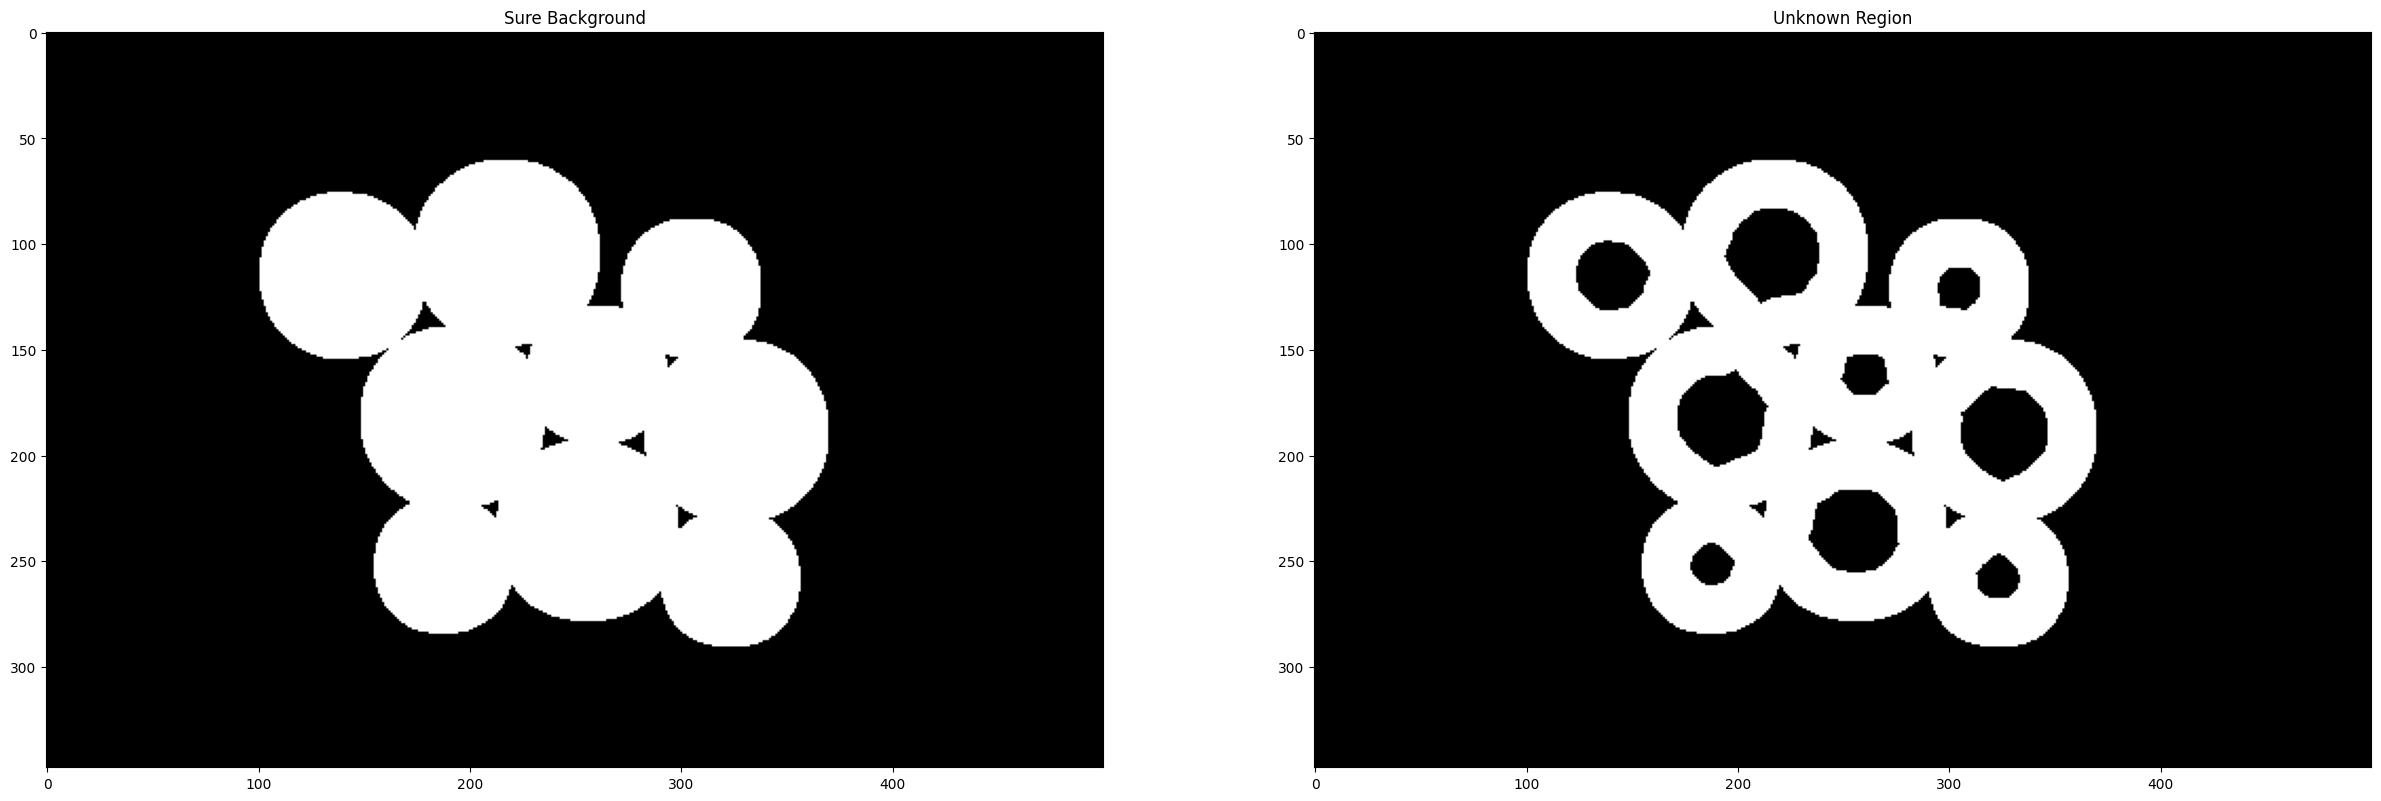

In [6]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

f, axarr = plt.subplots(1,2,figsize=(30,20))
axarr[0].imshow(sure_bg,'gray')
axarr[0].title.set_text('Sure Background')
axarr[1].imshow((unknown),'gray')
axarr[1].title.set_text('Unknown Region')

**Step 5**: Obtain the marker image that can be supplied to the watershed algorithm.

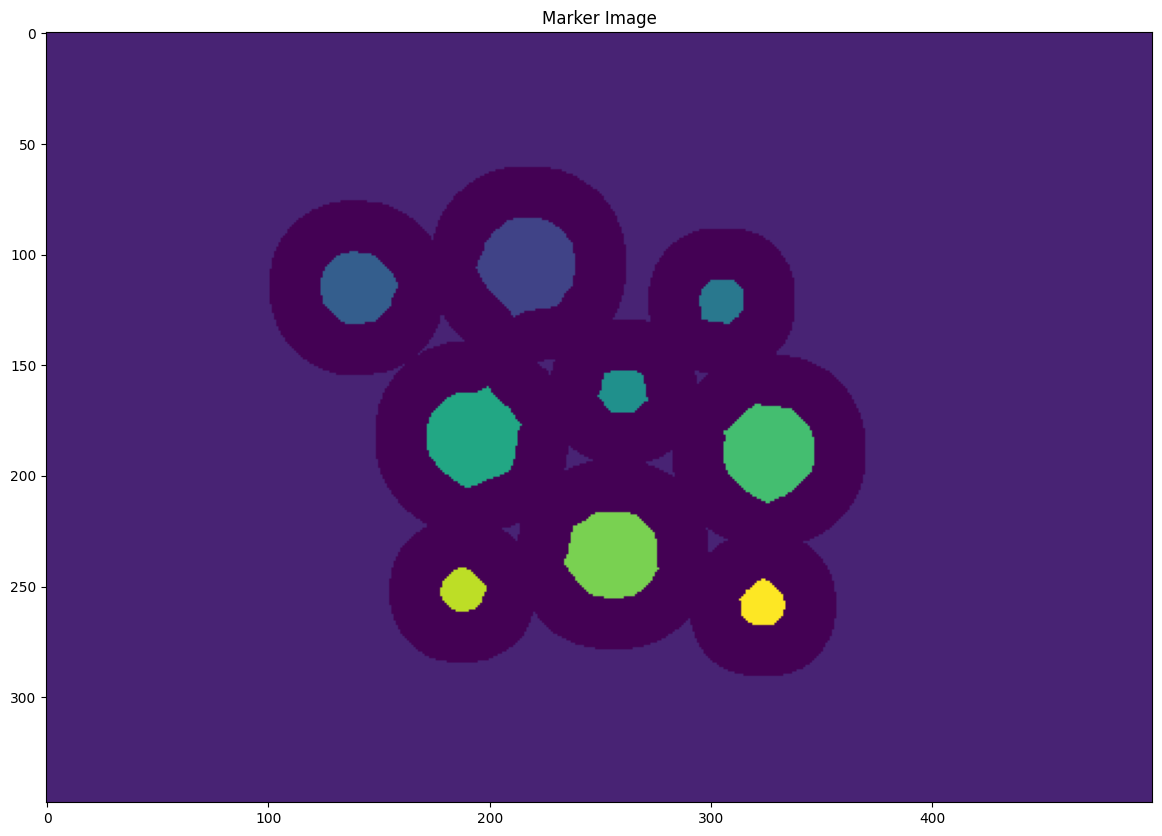

In [7]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# plot figure
plt.figure(figsize=(30,10))
plt.title('Marker Image')
plt.imshow(markers)

**Step 6**: Apply the watershed Algorithm and display results.

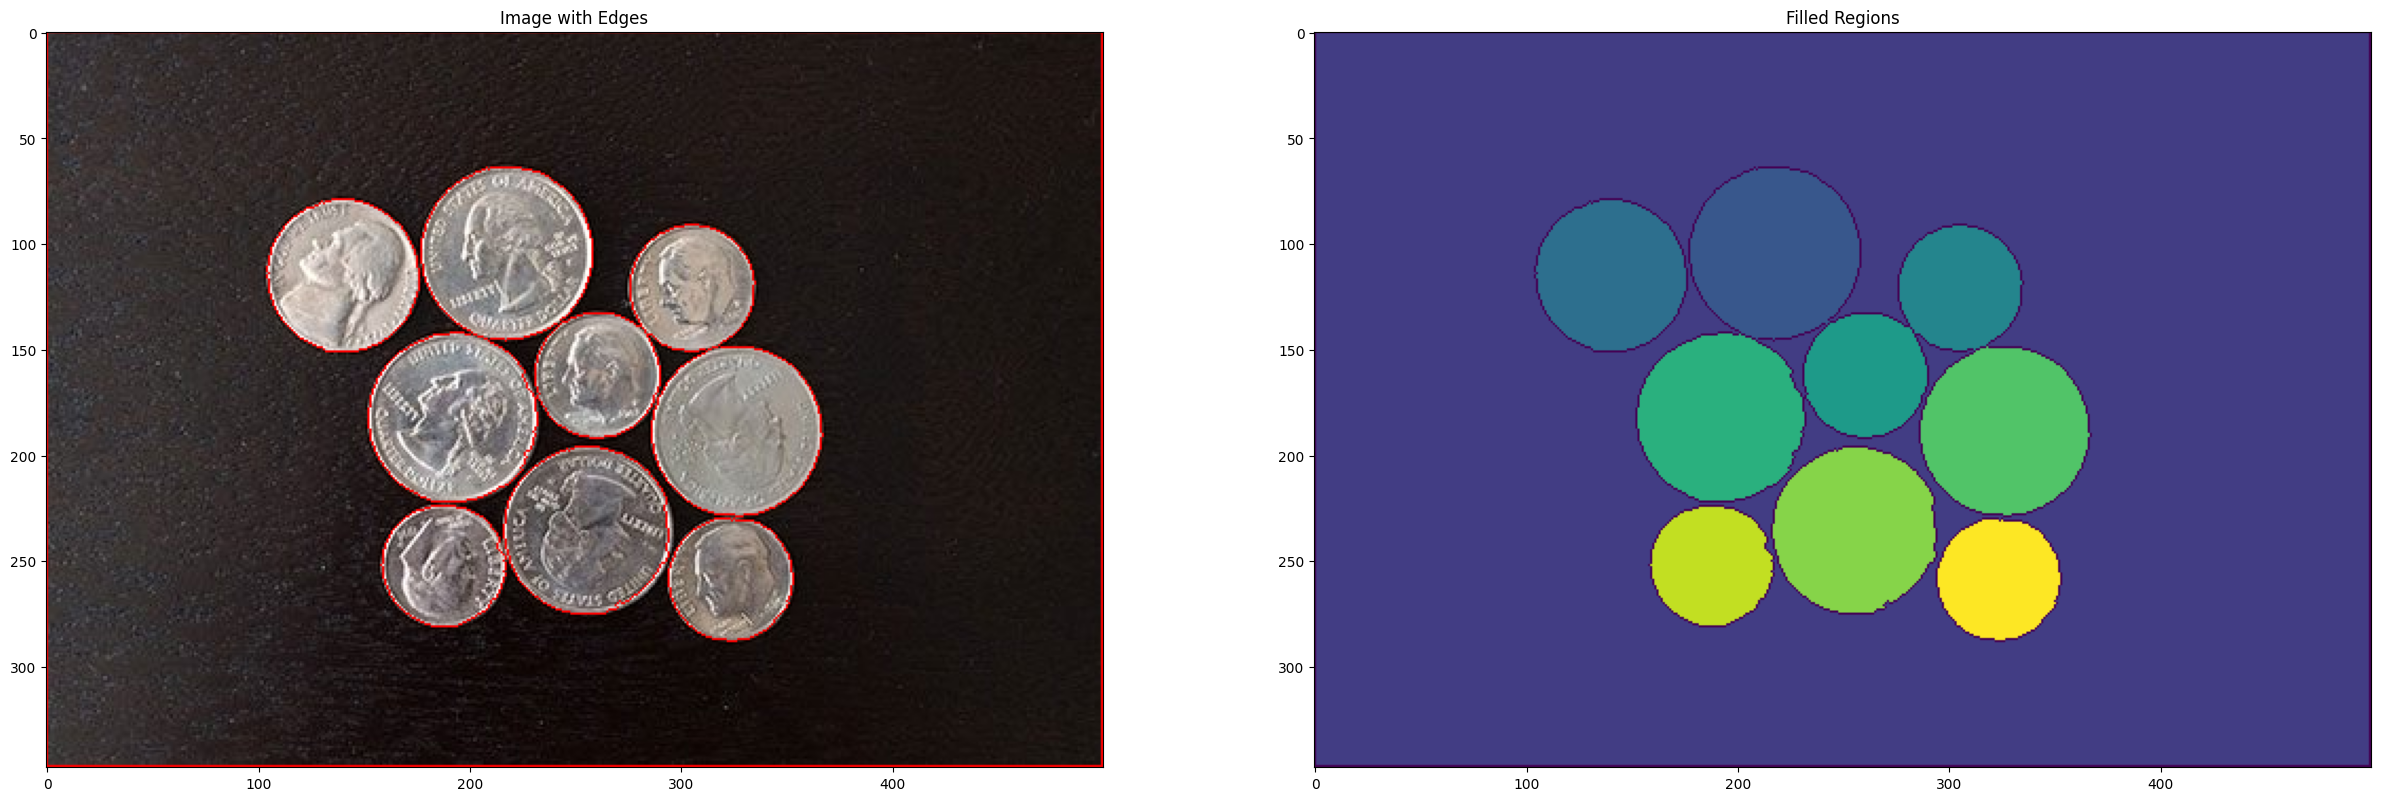

In [8]:
img= image
# Modify markers with watershed and display edges
markers = cv2.watershed(img,markers)
image[markers == -1] = [255,0,0]

# plot images
f, axarr = plt.subplots(1,2,figsize=(30,20))
axarr[0].imshow(image)
axarr[0].title.set_text('Image with Edges')
axarr[1].imshow(markers)
axarr[1].title.set_text('Filled Regions')